探究代码如何实现loupe中的归一化

In [ ]:
import torch
import torch.nn as nn

class Memc_LOUPE(nn.Module):
    def __init__(self, input_shape, slope, sample_slope, device, sparsity):
        super(Memc_LOUPE, self).__init__()
        self.input_shape = input_shape
        self.slope = slope 
        self.device = device
        self.add_weight_real = nn.Parameter(- torch.log(1. / torch.rand(self.input_shape, dtype=torch.float32) - 1.) / self.slope, requires_grad=True)
        self.add_weight_imag = nn.Parameter(- torch.log(1. / torch.rand(self.input_shape, dtype=torch.float32) - 1.) / self.slope, requires_grad=True)
        self.sample_slope = sample_slope
        self.sparsity = sparsity
        self.conv = nn.Conv2d(4, 2, 1, 1, 0)

    def calculate_Mask(self, kspace_mc, option):
        print('sparsity:',self.sparsity)
        logit_weights_real = 0 * kspace_mc[:,0, :, :] + self.add_weight_real
        logit_weights_imag = 0 * kspace_mc[:,1, :, :] + self.add_weight_imag
        prob_mask_tensor = torch.cat((logit_weights_real, logit_weights_imag), dim=1)
        prob_mask_tensor = self.conv(prob_mask_tensor)
        prob_mask_tensor = torch.sigmoid(self.slope * prob_mask_tensor)
        #分析变量对应关系
        
        xbar = torch.mean(prob_mask_tensor)
        r = self.sparsity / xbar
        beta = (1 - self.sparsity) / (1 - xbar)
        le = (torch.less_equal(r, 1)).to(dtype=torch.float32)
        prob_mask_tensor = le * prob_mask_tensor * r + (1 - le) * (1 - (1 - prob_mask_tensor) * beta)
        threshs = torch.rand(prob_mask_tensor.size(), dtype=torch.float32).to(device=self.device)
        thresh_tensor = 0 * prob_mask_tensor + threshs

        last_tensor_mask = torch.sigmoid(self.sample_slope * (prob_mask_tensor - thresh_tensor)) 
        return last_tensor_mask.to(device=self.device)

    def forward(self,mask):
        B,C,H,W=mask.shape
        assert H==256 and W==256
        dcmask = self.calculate_Mask(mask, option=True)#inital work
        return  dcmask

探究nn.Parameter生成的参数是否是同时优化，同一个梯度不同的初始值？还是不同的初始值？ 实际需要应该是按照每个点用不同的梯度进行更新，卷积？ 默认前面的已经学出来概率分布，看看归一化是怎么实现的

Text(0.5, 1.0, 'randn')

<Figure size 640x480 with 0 Axes>

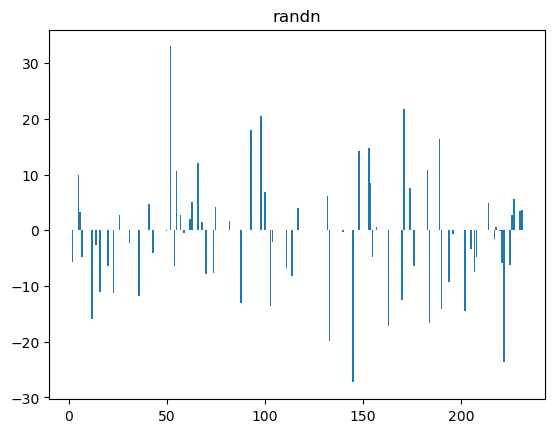

In [15]:
import torch
import torch.nn as nn

input_shape = [1,1,1,232]
add_weight = nn.Parameter(- torch.log(1. / torch.rand(input_shape, dtype=torch.float32) - 1.) / 0.17, requires_grad=True)
look=add_weight.detach().cpu().numpy()
import matplotlib.pyplot as plt
# plt.clf()
# plt.figure()
# plt.bar(range(232),look.squeeze())
# plt.title('rand')

add_weight1 = nn.Parameter(- torch.log(1. / torch.randn(input_shape, dtype=torch.float32) - 1.) / 0.17, requires_grad=True)
look1=torch.randn(input_shape, dtype=torch.float32).detach().cpu().numpy()
# import matplotlib.pyplot as plt
# plt.clf()
# plt.figure()
# plt.bar(range(232),look1.squeeze())
# plt.title('randn')

#单独初始化 concat到一起 会有问题吗？如何验证？


#单独初始化 concat到一起 会有问题吗？如何验证？

tensor(54.2339, grad_fn=<MaxBackward1>) tensor(-30.2911, grad_fn=<MinBackward1>)
add_weight1.shape: torch.Size([1, 1, 1, 24])
add_weight2.shape: torch.Size([1, 1, 1, 232])
add_weight.shape: torch.Size([1, 1, 1, 256])


Text(0.5, 1.0, 'add_weight')

<Figure size 640x480 with 0 Axes>

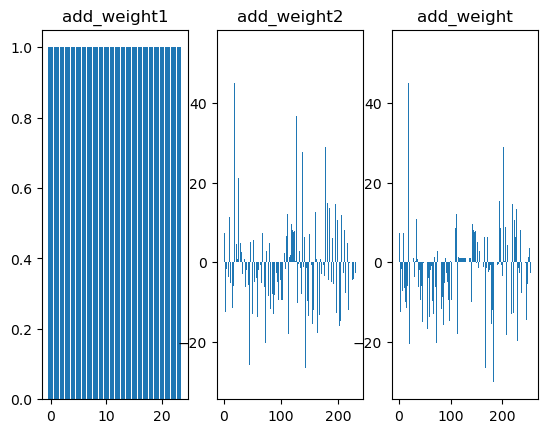

In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_shape1 = [1,1,1,24]
input_shape2 = [1,1,1,232]


add_weight2 = nn.Parameter(- torch.log(1. / torch.rand(input_shape2, dtype=torch.float32) - 1.) / 0.17, requires_grad=True)
add_weight1 = nn.Parameter(torch.ones(input_shape1, dtype=torch.float32), requires_grad=True)
# add_weight1=add_weight2.max()
print(add_weight2.max(),add_weight2.min())
maskl1=add_weight2[:,:,:,:116]
maskl2=add_weight2[:,:,:,116:]
mask_center = add_weight1
add_weight = torch.cat((maskl1,mask_center,maskl2),-1)
print('add_weight1.shape:',add_weight1.shape)
print('add_weight2.shape:',add_weight2.shape)
print('add_weight.shape:',add_weight.shape)

plt.clf()
plt.figure()
plt.subplot(131)
plt.bar(range(input_shape1[-1]),add_weight1.detach().cpu().numpy().squeeze())
plt.title('add_weight1')

plt.subplot(132)
plt.bar(range(input_shape2[-1]),add_weight2.detach().cpu().numpy().squeeze())
plt.title('add_weight2')

plt.subplot(133)
plt.bar(range(input_shape1[-1]+input_shape2[-1]),add_weight.detach().cpu().numpy().squeeze())
plt.title('add_weight')
# import matplotlib.pyplot as plt
# plt.clf()
# plt.figure()
# plt.bar(range(232),look1.squeeze())
# plt.title('randn')

#单独初始化 concat到一起 会有问题吗？如何验证？


保证中间位置一定为1 设置最大值作为初始值

tensor(30.0929, grad_fn=<MaxBackward1>) tensor(-37.3019, grad_fn=<MinBackward1>)
add_weight1.shape: torch.Size([1, 1, 1, 24])
add_weight2.shape: torch.Size([1, 1, 1, 232])
add_weight.shape: torch.Size([1, 1, 1, 256])


Text(0.5, 1.0, 'add_weight')

<Figure size 640x480 with 0 Axes>

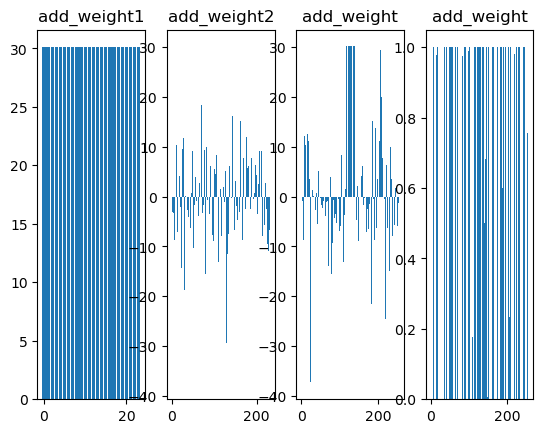

In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_shape1 = [1,1,1,24]
input_shape2 = [1,1,1,232]


add_weight2 = nn.Parameter(- torch.log(1. / torch.rand(input_shape2, dtype=torch.float32) - 1.) / 0.17, requires_grad=True)
add_weight1 = nn.Parameter(torch.ones(input_shape1, dtype=torch.float32), requires_grad=True)
add_weight1=add_weight2.max()*add_weight1
print(add_weight2.max(),add_weight2.min())
maskl1=add_weight2[:,:,:,:116]
maskl2=add_weight2[:,:,:,116:]
mask_center = add_weight1
add_weight = torch.cat((maskl1,mask_center,maskl2),-1)
print('add_weight1.shape:',add_weight1.shape)
print('add_weight2.shape:',add_weight2.shape)
print('add_weight.shape:',add_weight.shape)

plt.clf()
plt.figure()
plt.subplot(141)
plt.bar(range(input_shape1[-1]),add_weight1.detach().cpu().numpy().squeeze())
plt.title('add_weight1')

plt.subplot(142)
plt.bar(range(input_shape2[-1]),add_weight2.detach().cpu().numpy().squeeze())
plt.title('add_weight2')

plt.subplot(143)
plt.bar(range(input_shape1[-1]+input_shape2[-1]),add_weight.detach().cpu().numpy().squeeze())
plt.title('add_weight')

prob_mask_tensor = torch.sigmoid(5.0 * add_weight) #1channel #保证初始值在0-1

plt.subplot(144)
plt.bar(range(input_shape1[-1]+input_shape2[-1]),prob_mask_tensor.detach().cpu().numpy().squeeze())
plt.title('add_weight')
# import matplotlib.pyplot as plt
# plt.clf()
# plt.figure()
# plt.bar(range(232),look1.squeeze())
# plt.title('randn')

#单独初始化 concat到一起 会有问题吗？如何验证？


In [50]:
print(prob_mask_tensor.sum()/256)
prob_mask_tensor_test=torch.sigmoid(5.0 * add_weight2) #1channel #保证初始值在0-1
print(prob_mask_tensor_test.sum()/232)

tensor(0.5123, grad_fn=<DivBackward0>)
tensor(0.4619, grad_fn=<DivBackward0>)


In [37]:
print(add_weight.requires_grad)
# print(add_weight.is_leaf)
print(add_weight.all())

True
tensor(True)


测试是否每个节点都可以正常梯度更新

In [34]:
y = torch.sin(add_weight + 2 * add_weight)
y.sum().backward()
print(add_weight.requires_grad)  

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [28]:
import torch

x = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]], requires_grad=True)

y = x.detach()  # 分离x节点，得到叶子节点y
y[0][1].requires_grad = False
y[1][2].requires_grad = False

print(x.requires_grad)
print(x[0][0].requires_grad)
print(x[0][1].requires_grad)
print(x[1][0].requires_grad)
print(x[1][2].requires_grad)


True
True
True
True
True


In [29]:
import torch

# 创建一个张量，设置前两个元素的requires_grad为True，后两个元素的requires_grad为False
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
x[:2].requires_grad = True
x[2:].requires_grad = False

# 对张量进行一些操作，生成新的张量y
y = x ** 2 + torch.sin(x)

# 对新的张量进行反向传播，并检查所有元素的梯度是否不为None
y.sum().backward()
print(x.grad)


RuntimeError: you can only change requires_grad flags of leaf variables.

In [30]:
import torch

# 创建一个张量，设置前两个元素的requires_grad为True，后两个元素的requires_grad为False
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
x1 = x[:2]
x2 = x[2:]
x1.requires_grad = True
x2.requires_grad = False

# 对张量进行一些操作，生成新的张量y
y = x ** 2 + torch.sin(x)

# 对新的张量进行反向传播，并检查所有元素的梯度是否不为None
y.sum().backward()
print(x.grad)


RuntimeError: you can only change requires_grad flags of leaf variables.